In [20]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 检查是否有可用的GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
dir = r'D:/R/PycharmProjects/interest/Tox2024/Tox_3/data/'
ahr = dir + 'AUG/ahr_35x_test.csv'
Label_file = dir + 'MODELS/ahr_label.pkl'

data = pd.read_csv(ahr)
smiles_data = data['SMILES']
activity_data = data['ACTIVITY']
pos = len(data[data['ACTIVITY'] == 1])
neg = len(data[data['ACTIVITY'] == 0])
print(f"Positive: {pos}, Negative: {neg}, Ratio: {neg/pos}")
data.head()

Positive: 2916, Negative: 3595, Ratio: 1.2328532235939644


,SMILES,ACTIVITY
0,C(O)(=O)C.C1[C@H]2[C@](C)(CN)CCC[C@]2(C)c2c(cc...,0
1,C[C@@]1(CN)CCC[C@]2(C)c3ccc(C(C)C)cc3CC[C@H]21...,0
2,[C@@]1(CN)(C)CCC[C@]2(C)c3ccc(C(C)C)cc3CC[C@@H...,0
3,CC(O)=O.[H][C@@]12CCC3=CC(=CC=C3[C@@]1(C)CCC[C...,0
4,O=C(O)C.C1[C@@](C)(CN)[C@@H]2CCc3c(ccc(C(C)C)c...,0


204/204 [==============================] - 9s 45ms/step
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      3595
           1       0.82      0.79      0.81      2916

    accuracy                           0.83      6511
   macro avg       0.83      0.83      0.83      6511
weighted avg       0.83      0.83      0.83      6511

[[3106  489]
 [ 618 2298]]
204/204 [==============================] - 9s 44ms/step
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      3595
           1       0.85      0.76      0.80      2916

    accuracy                           0.83      6511
   macro avg       0.83      0.82      0.83      6511
weighted avg       0.83      0.83      0.83      6511

[[3211  384]
 [ 714 2202]]
204/204 [==============================] - 9s 44ms/step
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3595
           1   

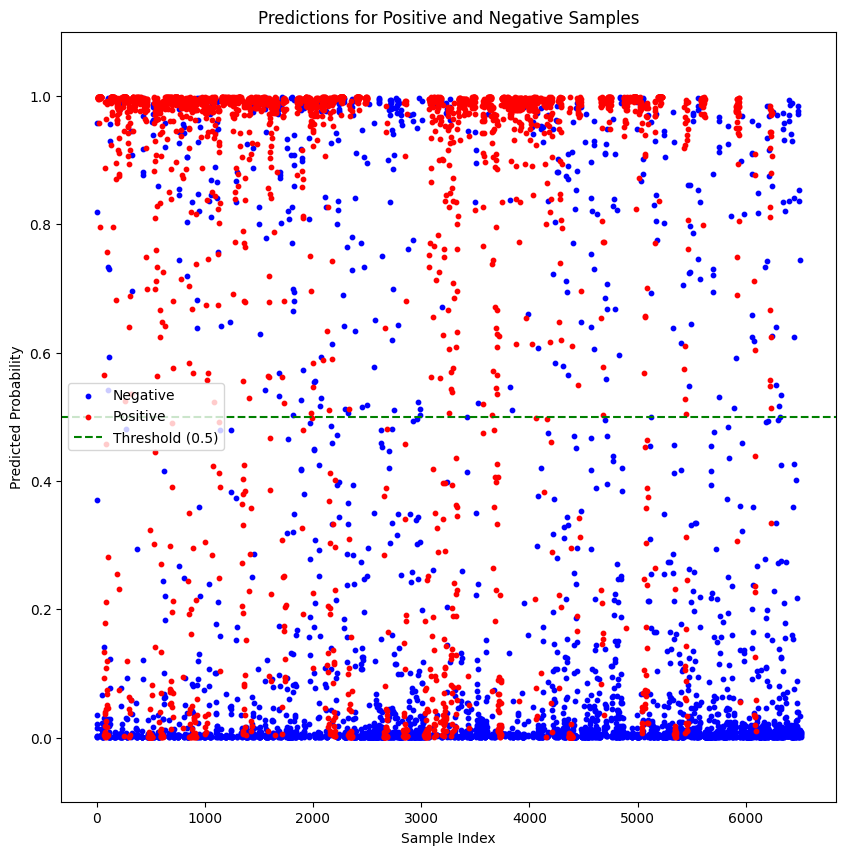

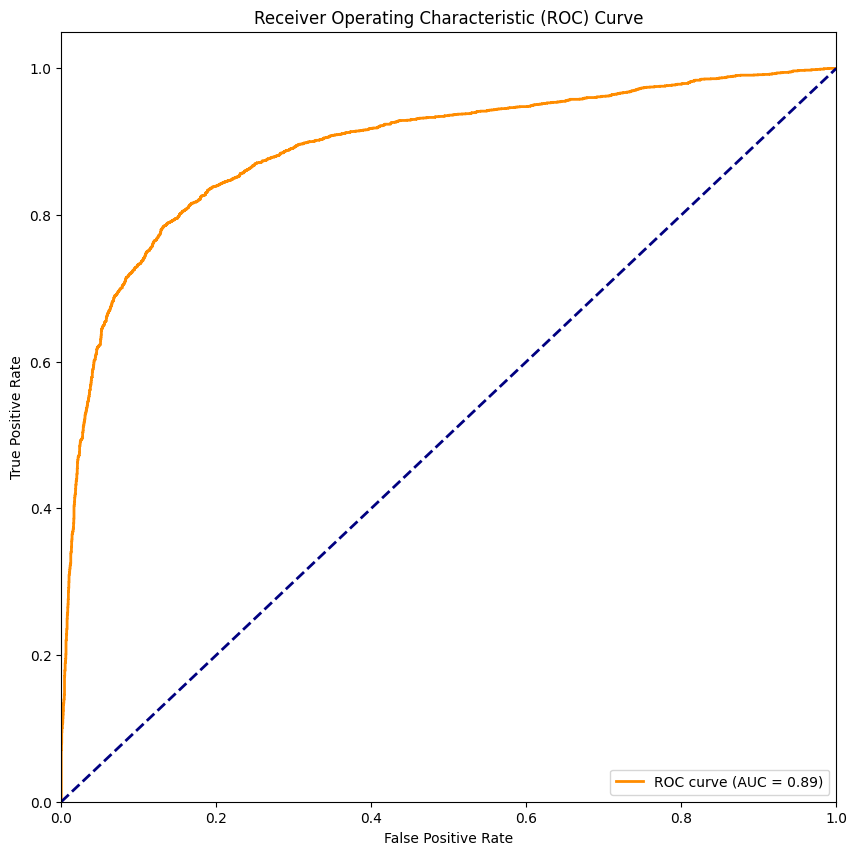

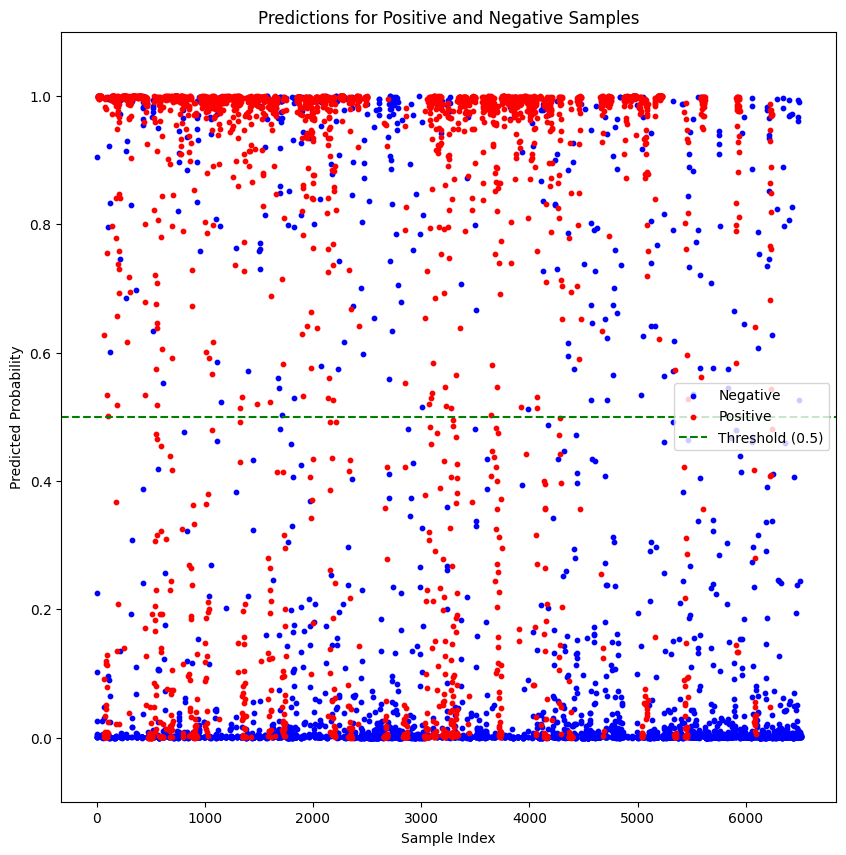

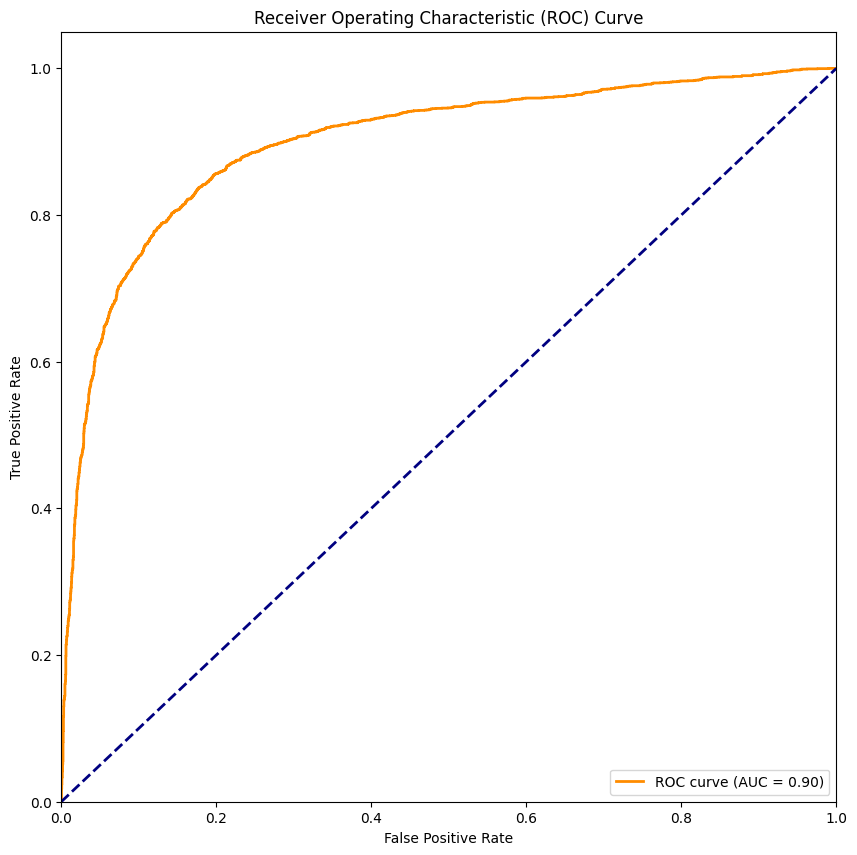

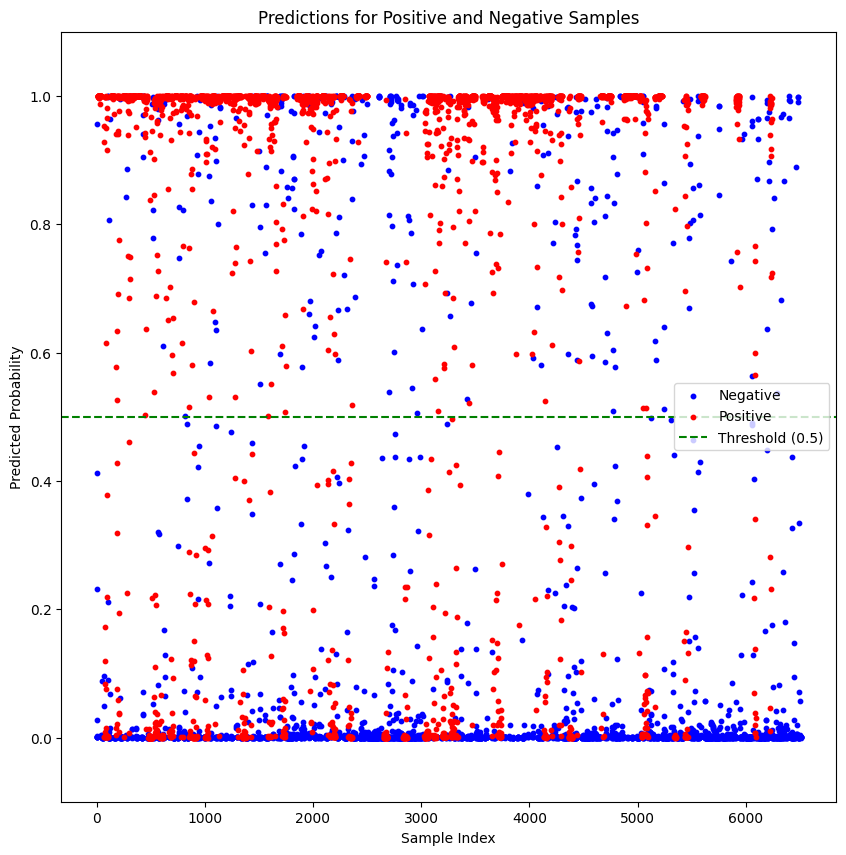

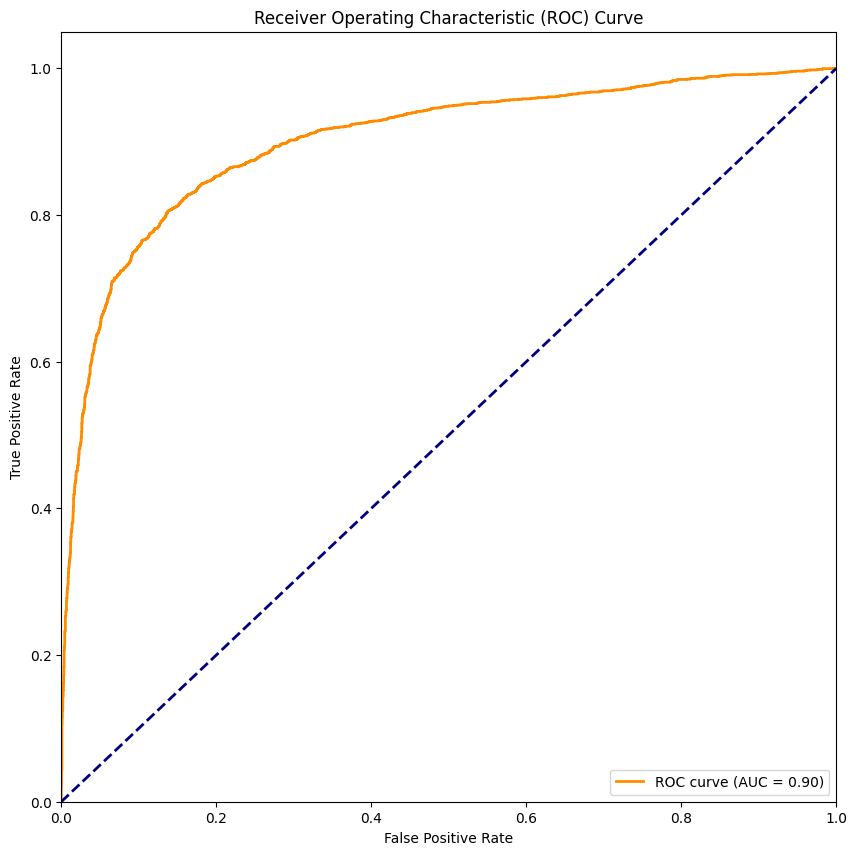

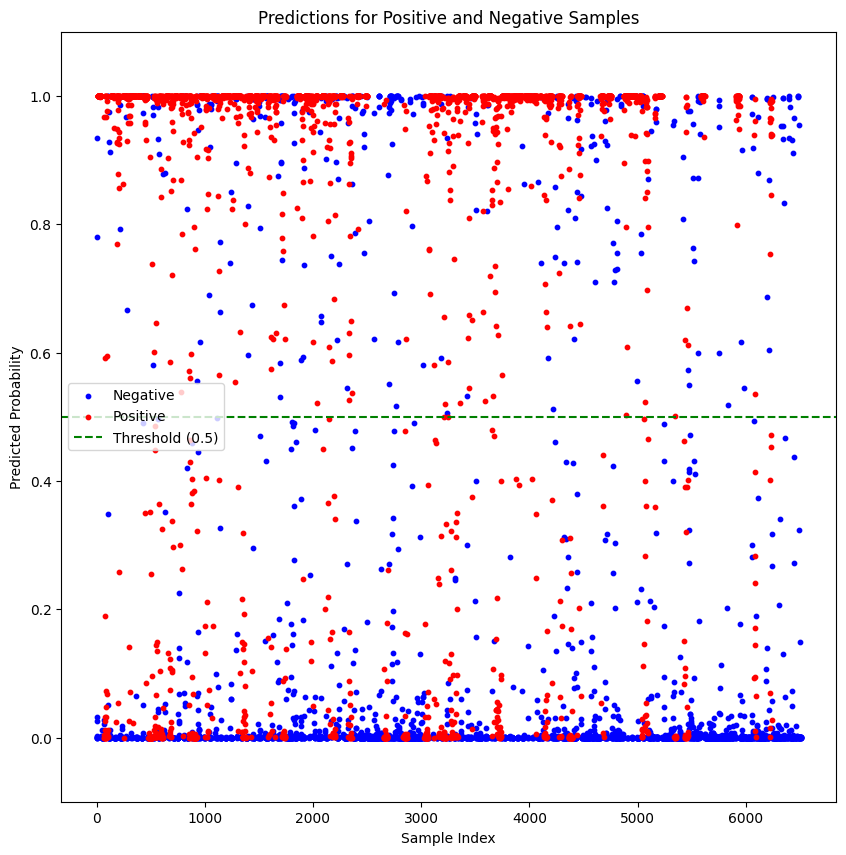

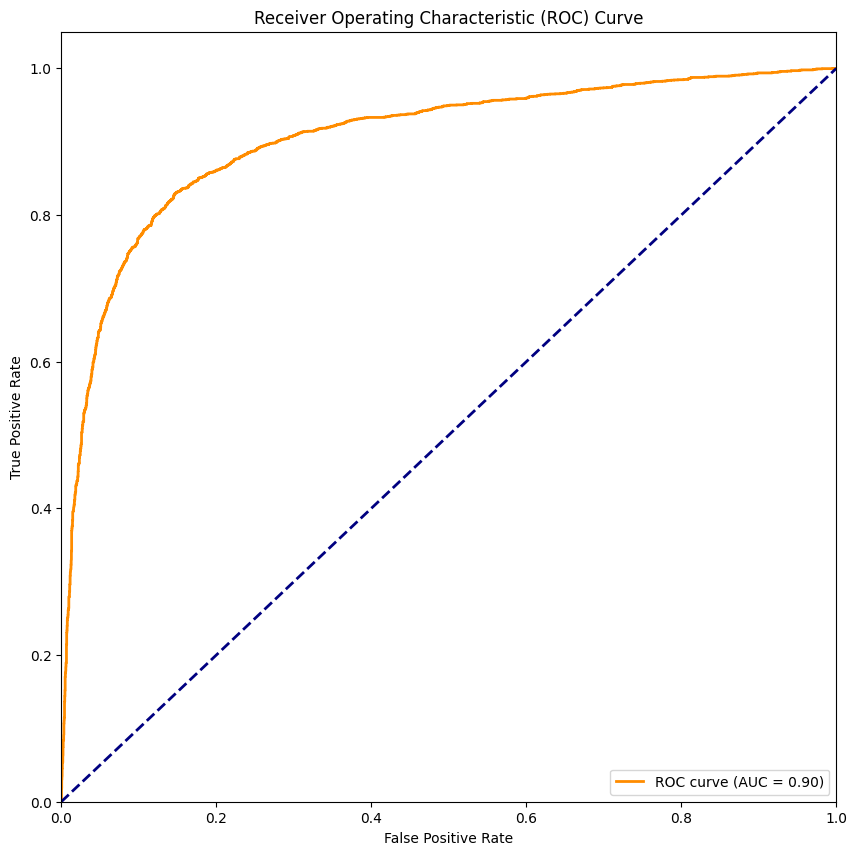

In [22]:
with open(Label_file, 'rb') as f:
    tokenizer = pkl.load(f)

# 数据预处理
max_length = 128
smiles_data = tokenizer.texts_to_sequences(smiles_data)
smiles_data = pad_sequences(smiles_data, maxlen=max_length, padding='post', truncating='post')
y_test = np.array(activity_data)

# 定义模型参数
vocab_size = len(tokenizer.word_index) + 1

# 将整数序列转换为one-hot编码
x_onehot = np.eye(vocab_size)[smiles_data]

for i in range(1, 5):
    model_file = dir + f'ahr_MODELS/ahr_35x_model_v{i}.h5'
    pic_file = dir + f'ahr_MODELS/ahr_35x_test_v{i}.pdf'
    ROC_file = dir + f'ahr_MODELS/ahr_35x_ROC_v{i}.pdf'

    model = load_model(model_file)
    
    # 评估模型
    y_pred = model.predict([x_onehot])
    thread = 0.5    
    y_max = np.where(y_pred > thread, 1, y_pred)
    y_max = np.where(y_max < thread, 0, y_max)
    print(classification_report(y_test, y_max))
    print(confusion_matrix(y_test, y_max))

    # 创建图形
    plt.figure(figsize=(10, 10))

    # 绘制阴性样本（标签为 0）
    plt.scatter(np.arange(len(y_test))[y_test == 0], y_pred[y_test == 0], 
                color='blue', label='Negative', alpha=1, s=10)

    # 绘制阳性样本（标签为 1）
    plt.scatter(np.arange(len(y_test))[y_test == 1], y_pred[y_test == 1], 
                color='red', label='Positive', alpha=1, s=10)

    # 添加一条阈值线（默认为 0.5）
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    # 设置图表标题和轴标签
    plt.title('Predictions for Positive and Negative Samples')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probability')

    plt.legend()  # 添加图例
    plt.ylim(-0.1, 1.1)  # 调整y轴的范围
    plt.savefig(pic_file)  # 显示图形

    # 计算 ROC 曲线的点
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)  # 计算 AUC

    # 绘制 ROC 曲线
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(ROC_file)